# Project: Breast Cancer Incidence
***Group Members :***
    
    Kayleigh Habib - 200370580 - kayl26
    Myisha Chaudhry - 200591740 - myishac
    
***GitHub: https://github.com/wlu-labs/final-project-200370580-200591740***

# Introduction
The purpose of this analysis is to determine whether machine learning algorithms can be be more effective than current practice for predicting whether a mass indicated in a mammogram is benign or malignant.

In [1]:
# to catch any warnings
import warnings
warnings.filterwarnings("ignore")

# Load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages that will be used in PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import packages that will be used in model building and evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, r2_score


## Load and Describe Data

The data used was retrieved from the University of California, Irvine (UCI) Machine Learning repository (http://archive.ics.uci.edu/ml/datasets/mammographic+mass) and consists of data that was collected by the Institute of Radiology of the University Erlangen-Nuremberg, Germany.


In [2]:
#Load Data
mammogramdata = pd.read_csv("mammographic_masses.data", names = ["BI-RADS assessment", "Age", "Shape", "Margin", "Density", "Severity"])
mammogramdata.replace("?", np.nan, inplace=True)
mammogramdata.head(5)


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,NaN,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,NaN,1


In [3]:
# Look at the makeup of the data
mammogramdata.info()
#961 rows of 5 variables and 1 target (severity)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BI-RADS assessment  959 non-null    object
 1   Age                 956 non-null    object
 2   Shape               930 non-null    object
 3   Margin              913 non-null    object
 4   Density             885 non-null    object
 5   Severity            961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


### Attribute Information

The data contains 961 records of mammogram masses in 6 columns. These columns contain the following information:

BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)

Age: patient's age in years (integer)

Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

Severity: benign=0 or malignant=1 (binominal, target)


The Breast Imaging Reporting and Data System (BI-RADS) assessment is assigned by a doctor after examination of the mammogram results. As this is based primarily of the shape, margin, and density attributes, it is considered non-predictive so it will not be used in the model. Instead, this can be used to compare against the model predictions to determine whether any of the models out-perform these assessments.

Severity is the target variable and denotes whether a mass is assessed to be benign (non-cancerous) or malignant.

# Review and Clean Data

In [4]:
#The BI-RADS variable is not-predictive so it is removed from the data
mammoData = mammogramdata.drop(['BI-RADS assessment'], axis=1)
mammoData.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,NaN,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,NaN,1


In [5]:
#Check for missing values
missing_mammvalues = mammoData.isnull().sum().sort_values(ascending = False)
missing_mammvalues 
# missing values exist for each one of the predictors. No missing values in target.

Density     76
Margin      48
Shape       31
Age          5
Severity     0
dtype: int64

In [6]:
#Most of the records with missing values may have to be dropped
#Examine whether a subsitution can be made for missing Age which occurs in only 5 cases

#change Age to integer
# Given the distribution of age (range from 18 to 96),
#substitute median for the missing Age values
mammoData['Age'] = mammoData['Age'].fillna(mammoData['Age'].median()).astype('int')

mammoData['Age'].describe()

count    961.000000
mean      55.495317
std       14.442783
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

In [7]:
#Drop the records that still contain missing values
mammoData = mammoData.dropna()
mammoData.info()
#there are 836 records remaining

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 960
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       836 non-null    int64 
 1   Shape     836 non-null    object
 2   Margin    836 non-null    object
 3   Density   836 non-null    object
 4   Severity  836 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [8]:
# Change Density variable to integer as it is an ordinal value
mammoData['Density'].astype('int')
mammoData['Density'].value_counts(ascending=False)

3    761
2     56
1     11
4      8
Name: Density, dtype: int64

# Model Planning

## Exploratory Data Analysis
We now look at the distribution of variables in the data and how the attributes are related to the target. Based on the following charts, the dataset seems well-balanced with respect to the target (51% benign and 49% malignant). 

In [9]:
#Look at distribution of target variable in the data

mammoData['Severity'].value_counts(normalize = True)

# Data is balanced with about 51% benign cases and 49% malignant cases

0    0.511962
1    0.488038
Name: Severity, dtype: float64

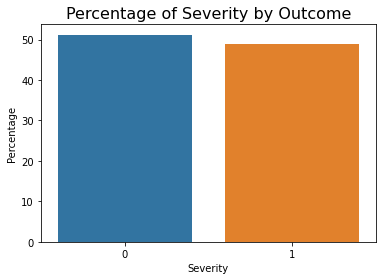

In [10]:
#Look at distribution of target variable in the data

plotData =mammoData['Severity'].value_counts(normalize=True)*100
newData = plotData.to_frame().reset_index()
newData.columns = ['Severity', 'Percentage']
#ewData.head()

sns.barplot(data=newData, x='Severity', y ='Percentage');
plt.title('Percentage of Severity by Outcome', fontsize = 16);

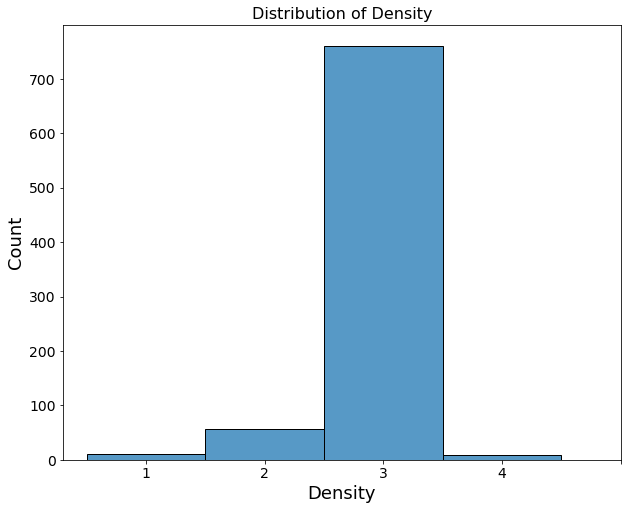

In [11]:
# Look at Distribution of Density variable
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Density", kde=False, data=mammoData.sort_values('Density'), ax=axes, bins=4);
axes.set(xlabel="Density");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.xticks([0,1,2,3,4]);
plt.title('Distribution of Density', fontsize=16);

#The majority of masses are classified as Density 3 (low)

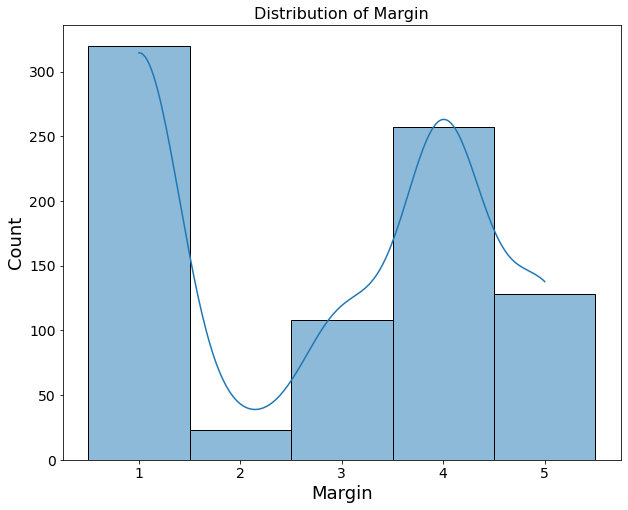

In [12]:
mammoData['Margin'].value_counts(ascending =False)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Margin", kde=True, data=mammoData.sort_values('Margin'), ax=axes, bins=5);
axes.set(xlabel="Margin");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.title('Distribution of Margin', fontsize=16);

# Most of the mammogram masses are in either the 1 or 4 category i.e. circumscribed or ill-defined

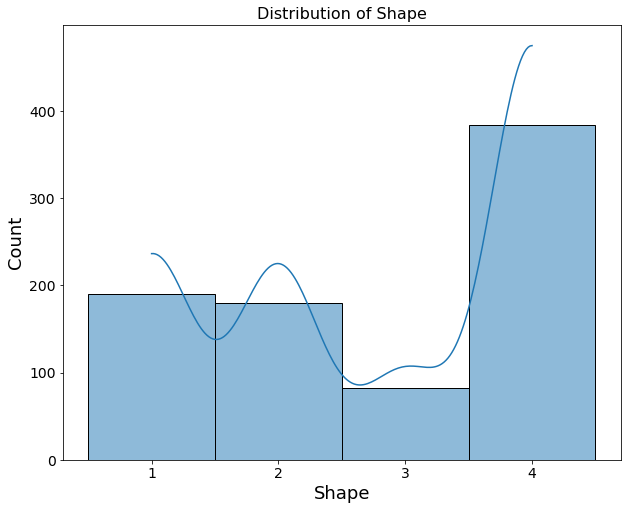

In [13]:
mammoData['Shape'].value_counts(ascending =False)

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram to look for distribution as well as outliers
sns.histplot(x="Shape", kde=True, data=mammoData.sort_values('Shape'),ax=axes, bins=4);
axes.set(xlabel="Shape");
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);
plt.title('Distribution of Shape', fontsize=16);

# Category 3 (lobular) contains the least number of records

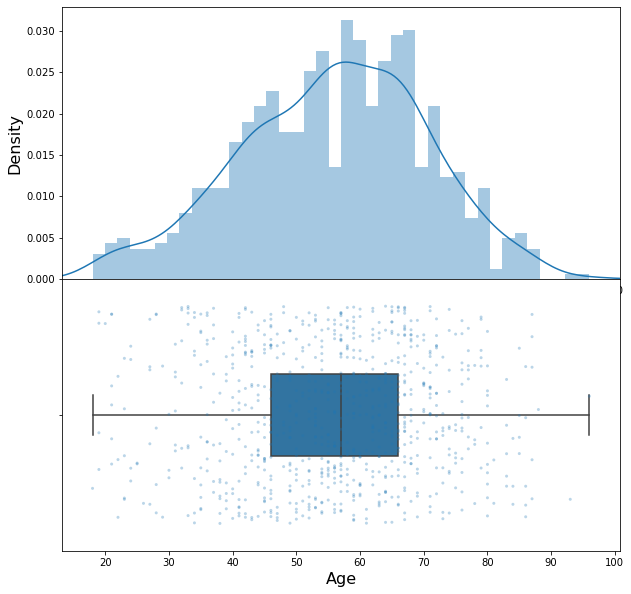

In [14]:
# Look at distribution of Age

fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

sns.distplot(
   mammoData['Age'].values, 
    kde=True,
    bins = 40,
    ax=axs[0]
)

sns.stripplot(
    mammoData['Age'].values, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)

sns.boxplot(
    mammoData['Age'].values,
    width=0.3, 
    ax=axs[1]
)

# Align axes
spacer = np.max(mammoData['Age']) * 0.05
xmin = np.min(mammoData['Age']) - spacer
xmax = np.max(mammoData['Age']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

axs[1].set(xlabel='Age');
axs[1].xaxis.label.set_size(16)
axs[0].yaxis.label.set_size(16)


# Put the two plots together
plt.subplots_adjust(hspace=0)
plt.show()
# Adjust boxplot fill to be white
#axs[1].artists[0].set_facecolor('white')

## Relationships between Features and Response

We now examine how each of the feature variables is related to the target. Based on these charts we note the following:

a. Density category 2 (iso) has a lower proportion of breast cancer than the other categories.

b. Shape categories 1 and 2 have lowest proportion of breast cancer. The incidence rate is about 50% for shape category 3, and increases to almost 80% for Shape category 4.

c. Margin category 1 has low proportion of breast cancer (about 12%). The incidence rate increases with each subsequent category, and is highest for Margin category 5.

d. Breast cancer appears to be more likely at higher ages.

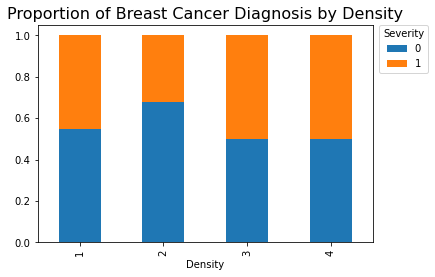

In [15]:
#create a stacked bar chart to show incidence of breast cancer by each Density class
pd.crosstab(mammoData['Density'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Density", fontsize=16);
#plt.legend(loc='center right', title='Severity')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');

#Density category 2 (iso) has a lower proportion of breast cancer than the other categories.

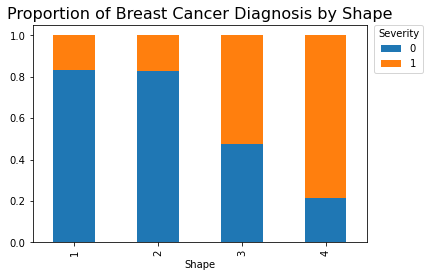

In [16]:
#create a stacked bar chart to show incidence of breast cancer by each shape class
pd.crosstab(mammoData['Shape'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Shape", fontsize=16);
#plt.legend(loc='center right', title='Severity')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');

#Shape categories 1 and 2 have lowest proportion of breast cancer. The incidence rate is about 50% for shape category 3,
#and increases to almoat 80% for Shape category 4.

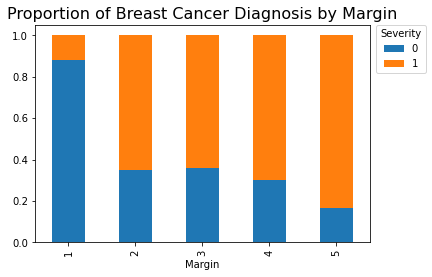

In [17]:
#create a stacked bar chart to show incidence of breast cancer by each margin class
pd.crosstab(mammoData['Margin'],mammoData['Severity'],normalize='index').plot.bar(stacked=True)
plt.title("Proportion of Breast Cancer Diagnosis by Margin", fontsize=16);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Severity');
#Margin category 1 has low proportion of breast cancer. The rate increases with each subsequent category,
#and is highest for Margin category 5.

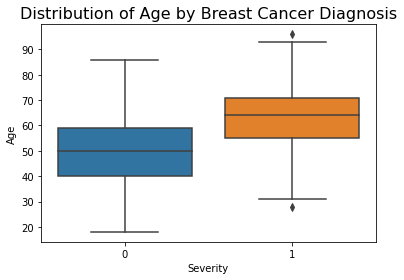

In [18]:
sns.boxplot(data=mammoData, x="Severity", y="Age")
plt.title('Distribution of Age by Breast Cancer Diagnosis', fontsize=16)
sns.set(rc = {'figure.figsize':(8,6)});
#Incidence of breast cancer appears to be more likely at higher ages

## Feature Engineering

## 1. Principal Component Analysis
Principal components analysis (PCA) is an unsupervised learning method that can be used to identify key variables, or to identify the presence of outliers in the data. In the mammographic mass data, there are only 4 features, so it is not considered high-dimensional. However, we will explore the application of PCA to better understand the relationships between the features.

Based on the PCA analysis, we noted the following:

a. For the first component, margin has the strongest effect

b. For the second and third components, age and density have a strong effect

c. For the fourth component shape has the most impact


In [19]:
#Explore Principal Components Analysis 

#Scale the feature columns
scaler = StandardScaler()
mammo_feat = mammoData.drop(['Severity'], axis=1)
scaler.fit(mammo_feat)
mammo_feat_s = scaler.transform(mammo_feat)  

col_names = list(mammo_feat.columns.values)
mammo_feat_s = pd.DataFrame(mammo_feat_s, columns=col_names)
mammo_feat_s.head()

#fit PCA transformation
pca = PCA()
mammo_pca = pca.fit_transform(mammo_feat_s)

# Reformat and view results
loadings = (pd.DataFrame(pca.components_, columns=['pc1', 'pc2', 'pc3','pc4'],
                            index=mammo_feat_s.columns))
print(loadings)

mammo_pca = pd.DataFrame(mammo_pca, columns = ['pc1', 'pc2', 'pc3','pc4'])
mammo_pca.head()

#Based on the PCA analysis, we noted the following:
# For the first component, age and margin have a strong effect
# For the second and third components, age and density have a strong effect
# For the fourth component shape has the most impact

              pc1       pc2       pc3       pc4
Age     -0.469405 -0.609182 -0.623743 -0.139644
Shape    0.127863  0.094379  0.032516 -0.986756
Margin   0.871943 -0.385116 -0.294938  0.066432
Density -0.055008 -0.686786  0.723117 -0.048988


,pc1,pc2,pc3,pc4
0,-1.366278,-0.076910,0.208880,0.837132
1,-1.568126,-0.079602,-0.638605,0.317481
2,2.463825,-0.653494,-0.743430,0.241689
3,-0.063039,-0.316555,0.232904,1.981848
4,-0.274646,-0.171074,1.555333,1.447982


,pc1,pc2,pc3,pc4,Severity
0,-1.366278,-0.076910,0.208880,0.837132,1
1,-1.568126,-0.079602,-0.638605,0.317481,1
2,2.463825,-0.653494,-0.743430,0.241689,0
3,-0.063039,-0.316555,0.232904,1.981848,1
4,-0.274646,-0.171074,1.555333,1.447982,1


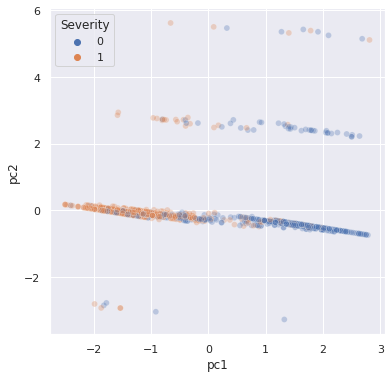

In [20]:
#Create a plot of the target based on the first 2 principal components
mammo_target = mammoData.loc[:,'Severity'].reset_index(drop=True)
concatenated = pd.concat([mammo_pca, mammo_target], axis=1)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="pc1", y="pc2",
    hue= "Severity",
    data=concatenated,
    legend="full",
    alpha=0.3
)
concatenated.head()

#From the graph, it appears that the two classes (benign and malignant), when projected to a two-dimensional space,
#can be separable.

In [21]:
print('Explained variation per principal component: {}'.format((pca.explained_variance_ratio_)*100))

Explained variation per principal component: [51.64260507 24.54675435 17.36215765  6.44848294]


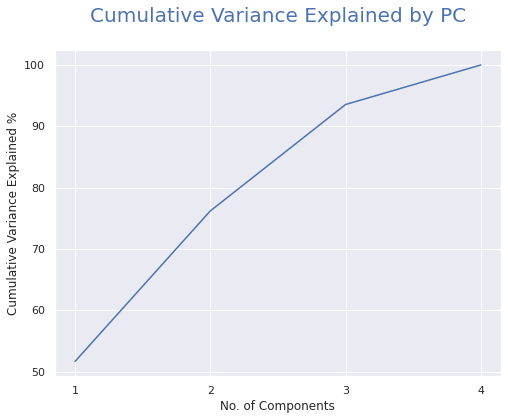

In [22]:
df = pd.DataFrame({'Cumulative Variance Explained %':np.cumsum(pca.explained_variance_ratio_)*100,
             'No. of Components':['1','2', '3', '4']})
sns.lineplot(x='No. of Components',y="Cumulative Variance Explained %", data=df, color="b")
plt.title("Cumulative Variance Explained by PC\n", fontsize=20, color="b")
plt.show()

#The graph shows that over 90% of the variance is explained by the first 3 principal components. 
#While not a material decrease from all 4 features available in the data, it is possible to use
#principal component analysis to decrease model run time without material decrease in performance.

## 2. One-Hot-Encoding 
One-hot-encoding is applied to nominal variables to transform them so each level of the feature becomes a new column with a value of 0 or 1 assigned, based on whether the level exists for a specific record. In order to remove collinearity, one level (i.e. new column) of the transformed variable is dropped from the data.

In [23]:
#As there are ordinal, nominal and numeric fields, fix data to be consistent with their types

#Apply one-hot-encoding to the nominal (catergorical) fields (Shape and Margin)
#Need to drop one of the levels for each - drop first level
cat_features = ['Shape', 'Margin']
mammoData_ohe = pd.get_dummies(mammoData, columns = cat_features, drop_first=True)
#cols = list(df_mam.columns.values)
#quantitative_cols = ['score', 'shape', 'margin', 'density']

# Re-order columns so target (Severity) is at the end
col_names = ['Age', 'Density', 'Shape_2', 'Shape_3', 'Shape_4', 'Margin_2', 'Margin_3', 
             'Margin_4', 'Margin_5', 'Severity']
mammoData_ohe = mammoData_ohe[col_names]
print(mammoData_ohe.head())
print(mammoData_ohe.info())

    Age Density  Shape_2  Shape_3  Shape_4  Margin_2  Margin_3  Margin_4  \
0    67       3        0        1        0         0         0         0   
2    58       3        0        0        1         0         0         0   
3    28       3        0        0        0         0         0         0   
8    57       3        0        0        0         0         0         0   
10   76       3        0        0        0         0         0         1   

    Margin_5  Severity  
0          1         1  
2          1         1  
3          0         0  
8          1         1  
10         0         1  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 960
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       836 non-null    int64 
 1   Density   836 non-null    object
 2   Shape_2   836 non-null    uint8 
 3   Shape_3   836 non-null    uint8 
 4   Shape_4   836 non-null    uint8 
 5   Margin_2  836 non

## Correlation matrix
A heatmap is used to determine whether identify correlations between features. A stronger relationship will be represented by a darker blue shade in the matrix. If variables are highly correlated, this may add complexity without model improvement. Based on the following matrix, there does not appear to be any strong correlations between features, so there is no need to remove any from the analysis.

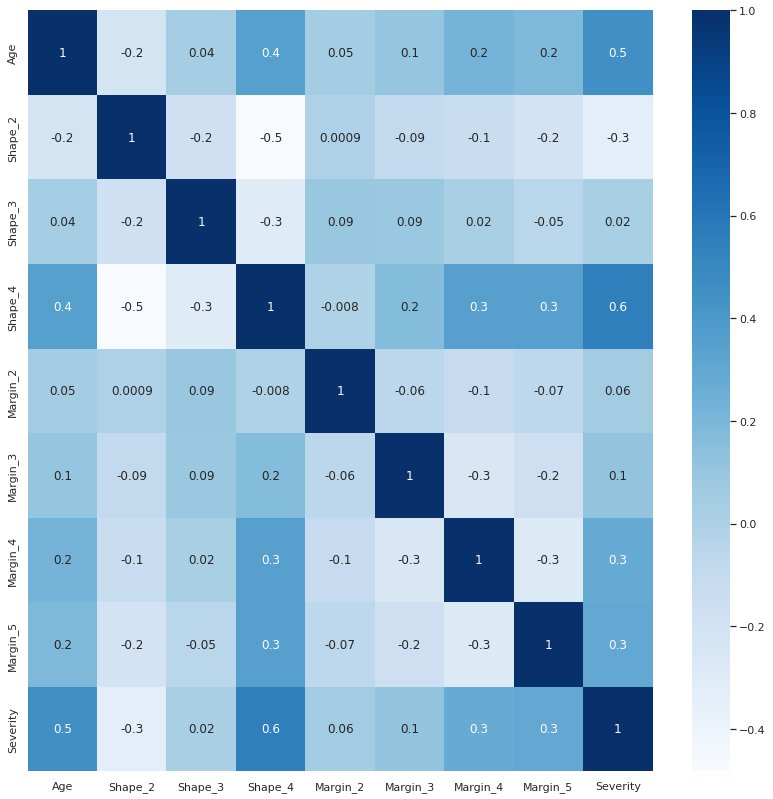

In [24]:
#Create a heatmap to look for any collinearity of features
fig, ax = plt.subplots(figsize=(14,14))  
sns.heatmap(mammoData_ohe.corr(),cmap='Blues', annot = True,fmt='.1g');

# Split Data into Train and Test

We start by splitting the data into a training set and a test set. The test set will be set aside to be used for comparing the performance of models only after all the models have been fitted.
When building models, it is possible that the model is over-fitted to data used for training and will thus perform poorly on unseen data. This is usually indicated by high training data accuracy, but low validation data accuracy. To avoid overfitting, we can 

a. further split the training data into separate train and validation datasets. The train dataset can be used for training the model, while the validation dataset is used to determine how well the model predicts on a new set of data 

OR 

b. use k-fold cross-validation to repeatedly split the training data into separate folds where each fold contains a set of train data as well as validation data. This is set up such that each record is in the validation set for at least one-fold.


In [25]:
#Split into train and test (train=80%, test=20%)
trainData, valData = train_test_split(mammoData_ohe, test_size=0.2, random_state=42)
X_train = trainData.drop(['Severity'], axis=1)
y_train = trainData.loc[:,'Severity']

X_test = valData.drop(['Severity'], axis=1)
y_test = valData.loc[:,'Severity']

In [26]:
#Scale features columns
#Note scaling in fit to the train data then applied to the test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)  
X_test_s = scaler.transform(X_test)

col_names = list(X_train.columns.values)
X_train_s = pd.DataFrame(X_train_s, columns=col_names)

X_test_s = pd.DataFrame(X_test_s, columns=col_names)

In [27]:
X_test_s.head()

,Age,Density,Shape_2,Shape_3,Shape_4,Margin_2,Margin_3,Margin_4,Margin_5
0,0.660923,0.234128,-0.538122,-0.328321,1.104205,-0.161597,-0.397130,1.535182,-0.412162
1,-0.097781,0.234128,-0.538122,-0.328321,1.104205,-0.161597,-0.397130,1.535182,-0.412162
2,1.281680,0.234128,-0.538122,-0.328321,1.104205,-0.161597,2.518067,-0.651389,-0.412162
3,-1.063403,0.234128,-0.538122,3.045804,-0.905629,6.188224,-0.397130,-0.651389,-0.412162
4,0.522977,0.234128,1.858315,-0.328321,-0.905629,-0.161597,-0.397130,-0.651389,-0.412162


## Model 1 - Logistic Regression

The first model will be a logistic regression, which will be used to classify the results as either benign (0) or malignant (1). The logistic regression model will determine the probability that a record belongs to one of these classes. In order to assign the record to a specific class, we then set a cut-off or threshold, so that if the probability exceed this amount, the record will be labelled as "1" i.e. malignant. The threshold can be set to reduce the occurrence of false positives and false negatives.

In [28]:
#Used for training only
class Logistic_Classifier:
    def __init__(self, X_train, y_train, random_state=42):
        """Initializes the class with the input features X and target variable y,
        and the random state used for reproducibility.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input feature matrix of shape (n_samples, n_features).
        y : pandas.Series
            The target variable of shape (n_samples,).
        random_state : int, default=RANDOM_STATE, which is 42
            The seed value for random number generator used to split the data.

        Returns:
        --------
        None"""

        self.best_params = {}
        self.best_score = 0
        
        self.X_train = X_train
        self.y_train = y_train
               
        self.random_state = random_state
        self.model = LogisticRegression(fit_intercept=True, random_state=self.random_state)
        
        return 
        
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "Logistic Regression"
    
    
    def fit(self, tune_fit="yes"):
        """Trains the model using the input data X and y.
        If tune_fit is set to "yes", it tunes the hyperparameters using GridSearchCV(), otherwise, with default parameters.
        It then stores the best hyperparameters and best estimator in the attributes best_params and model, respectively.

        Parameters:
        -----------
        tune_fit : str, default="yes"
            If "yes", tune the hyperparameters using GridSearchCV(), otherwise use default parameters.

        Returns:
        --------
        None
        """

        if tune_fit=="yes":
            param_grid = {'C':(0.1, 1),
                          'solver' :['newton-cg','lbfgs', 'liblinear'],
                          'penalty':['l1','l2']
                         }
                                       
            grid_search = GridSearchCV(self.model, param_grid, 
                                       cv=5)                                   
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)         
                       
        elif tune_fit=="no":
            self.model = self.model.fit(self.X_train, self.y_train)
            print(self.model.get_params()) 
            
        else:
            raise ValueError("Invalid value for `tune_fit`. Must be either 'yes' or 'no'.")
            
        return
            
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit
    
    
    def predict(self):
        """Predicts the target variable of the test data using the trained logistic regression model.
        Returns the predicted target variable values.

        Parameters:
        -----------
        None

        Returns:
        --------
        numpy.ndarray: The predicted target variable values
        
        """
        return self.model.predict(self.X_train)
    
   
    def score(self):
        """Computes the accuracy score and classification report for the predicted target variable and the actual test target variable.

        Parameters:
        -----------
        None

        Returns:
        --------
        accuracy score: The ratio of the correctly predicted observations to the total observations.
        
        classification report: A text report of the main classification metrics such as precision, recall, f1-score and support for each class."""
        
        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train, y_pred)
        report = classification_report(self.y_train, y_pred)
        
        return accuracy, report
    

In [29]:
# Create an instance of the Logistic classifier with default hyperparameters
lr_model = Logistic_Classifier(X_train_s, y_train)

# Fit the Logistic model to the training data
lr_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_lr = lr_model.predict()

accuracy_lr, classification_report_lr = lr_model.score()
print("The training accuracy achieved by tuned lr model:", accuracy_lr)
print('#'*60)
print("The training classification report of tuned lr model: \n", classification_report_lr)

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
The training accuracy achieved by tuned lr model: 0.8188622754491018
############################################################
The training classification report of tuned lr model: 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       346
           1       0.79      0.85      0.82       322

    accuracy                           0.82       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.82      0.82      0.82       668



## Model 2 - Decision Tree Model

A decision tree works by recursively dividing the inputs into decisions, where nodes represent features, and branches are the decisions made to divide the data. The leaves of the tree represent the outcome for each record. Decision tree models are very interpretable, but often suffer from over-fitting. This can be overcome by pruning the tree, or by setting limits on the number of leaf nodes.

In [30]:
class Decision_Tree_Classifier:

    def __init__(self, X_train, y_train, max_depth=1, RANDOM_STATE=42):
        self.X_train = X_train
        self.y_train = y_train
        
        self.model = DecisionTreeClassifier(max_depth=max_depth,random_state=RANDOM_STATE)
     
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "Decision Tree"  
    
    def fit(self, tune_fit="yes"):
       
        if tune_fit == "yes":
            self.model.fit(self.X_train, self.y_train)
            param_grid = {
                'min_samples_split': list(range(2, 12)),
                'min_samples_leaf': [10, 15],
                'max_depth': [2],
                'criterion': ['gini']
                }
            grid_search  = GridSearchCV(self.model, param_grid, cv=5)
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)
            
        else:
            self.model = self.model.fit(self.X_train, self.y_train)
            print(self.model.get_params())
        return 
    
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit
    
    def predict(self):
       
        self.y_pred = self.model.predict(self.X_train)
        return self.y_pred
   
   
    def calculate_metrics_classification(self):
        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train, y_pred)
        precision = precision_score(self.y_train, y_pred, average='macro')
        recall = recall_score(self.y_train, y_pred, average='macro')
        f1 = f1_score(self.y_train, y_pred, average='macro')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-Score:", f1)
        return accuracy, precision, recall, f1
       
    def plot(self):
        plt.figure(figsize=(15,10))
        tree.plot_tree(self.model, filled=True)
        plt.show()
        return
   
    
    def plot_importance(self):
        Importance = pd.DataFrame({'Importance':self.model.feature_importances_*100}, index=self.X_train.columns)
        Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
        plt.xlabel('Variable Importance')
        plt.gca().legend_ = None
        
        return
       
    def score(self):

        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train,y_pred)
        report = classification_report(self.y_train, y_pred)
        return accuracy, report

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2}
The training accuracy achieved by tuned dt model: 0.7934131736526946
############################################################
The training classification report of tuned dt model: 
               precision    recall  f1-score   support

           0       0.85      0.73      0.79       346
           1       0.75      0.86      0.80       322

    accuracy                           0.79       668
   macro avg       0.80      0.80      0.79       668
weighted avg       0.80      0.79      0.79       668



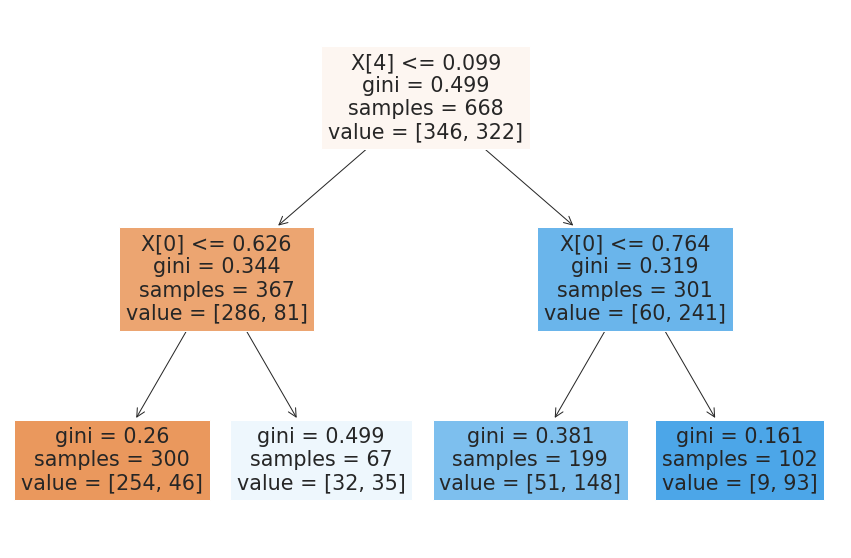

In [31]:
# Create an instance of the decision tree classifier
dt_model = Decision_Tree_Classifier(X_train_s, y_train)

# Fit the tree model to the training data
dt_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_dt = dt_model.predict()

accuracy_dt, classification_report_dt = dt_model.score()
print("The training accuracy achieved by tuned dt model:", accuracy_dt)
print('#'*60)
print("The training classification report of tuned dt model: \n", classification_report_dt)
dt_model.plot()

## Model 3 : K-nearest Neighbours Model
The K-nearest neighbours approach groups individual observations into categories based on its proximity to other similar data records. This methodology is relatively simple to implement due to the small number of parameters but does not perform well when data is high-dimensional as it tends to overfit.


In [32]:
#Used for training only
class KNN_Classifier:
    def __init__(self, X_train, y_train,  random_state=42):
        """
        Initialize the KNN classifier.

        Parameters:
        -----------
            X (pandas.DataFrame): The feature matrix of shape (n_samples, n_features).
            y (pandas.Series): The target vector of shape (n_samples,).
            n_neighbors (int, optional): The number of nearest neighbors to use in classification. Defaults to 5.
            test_size (float, optional): The proportion of samples to use for testing. Defaults to 0.2.
            random_state (int, optional): The random state to use for splitting the data. Defaults to 42.
        """
        
        self.model = KNeighborsClassifier()
        self.best_params = {}
        self.best_score = 0
        self.X_train = X_train
        self.y_train = y_train
        self.random_state = random_state
        
        return
        
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "KNN"
    
    def fit(self, tune_fit="yes"):
        """
        Fit the KNN model to the training data.

        Parameters:
        -----------
            tune_fit (str, optional): Whether to perform hyperparameter tuning. If "yes", performs a grid search to find
                the best hyperparameters. Defaults to "no".

        Raises:
        -----------
            ValueError: If `tune_fit` is not "yes" or "no".

        Returns:
        -----------
            None
        """
        if tune_fit=="yes": 
            param_grid = {'n_neighbors' : np.arange(2,11,3),
               'weights' : ['distance', 'uniform'],
               'metric' : ['minkowski', 'manhattan']
            }
            grid_search = GridSearchCV(self.model, param_grid, 
                                       #scoring = 'accuracy',
                                       cv=5)
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)
                        
        elif tune_fit=="no":
            self.model = self.model.fit(self.X_train, self.y_train)
            print(self.model.get_params()) 
        else:
            raise ValueError("Invalid value for `tune_fit`. Must be either 'yes' or 'no'.")
        return
        
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit    
    
    def predict(self):
        """
        Predict the target values for the test data.

        Parameters:
        -----------
        None

        Returns:
        -----------
            numpy.ndarray: The predicted target values of shape (n_samples,)
        """
        return  self.model.predict(self.X_train)
    
    def score(self):
        """
        Calculate the accuracy score and classification report for the KNN model.

        Parameters:
        -----------
        None

        Returns:
        -----------
        accuracy score: The ratio of the correctly predicted observations to the total observations.
        
        classification report: A text report of the main classification metrics such as precision, recall, f1-score and support for each class.
        """

        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train, y_pred)
        report = classification_report(self.y_train, y_pred)
        return accuracy, report


In [33]:
# Create an instance of the classifier
knn_model = KNN_Classifier(X_train_s, y_train)

# Fit the model to the training data
knn_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_knn = knn_model.predict()

accuracy_knn, classification_report_knn = knn_model.score()
print("The training accuracy achieved by tuned knn model:", accuracy_knn)
print('#'*60)
print("The training classification report of tuned knn model: \n", classification_report_knn)


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
The training accuracy achieved by tuned knn model: 0.842814371257485
############################################################
The training classification report of tuned knn model: 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       346
           1       0.81      0.89      0.84       322

    accuracy                           0.84       668
   macro avg       0.84      0.84      0.84       668
weighted avg       0.85      0.84      0.84       668



## Model 4: Random Forest

Random Forests combine multiple decision trees, each of which uses a random subset of features, and then aggregate the results of the trees to produce the outcome. Random forest models help reduce overfitting but can be time-consuming to run.

In [34]:
class Random_Forest_Classifier:
    def __init__(self, X_train, y_train, max_depth=1, random_state=42):
        """Initializes the RandomForest class with the input features X and target variable y,
        and the random state used for reproducibility.
        Parameters:
        -----------
        X : pandas.DataFrame
            The input feature matrix of shape (n_samples, n_features).
        y : pandas.Series
            The target variable of shape (n_samples,).
        random_state : int, default=RANDOM_STATE, which is 42
            The seed value for random number generator used to split the data.
        Returns:
        --------
        None"""

        self.X_train = X_train
        self.y_train = y_train
        self.random_state = random_state
            
        self.model = RandomForestClassifier(max_depth=1,random_state=self.random_state)
        self.best_params = {} 
        self.best_score = 0 
        return
     
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "Random Forest"
    
    def fit(self, tune_fit="yes"):
        """Trains the random forest model using the input data X and y.
        If tune_fit is set to "yes", it tunes the hyperparameters using GridSearchCV(), otherwise, with default parameters.
        It then stores the best hyperparameters and best estimator in the attributes best_params and model, respectively.
        Parameters:
        -----------
        tune_fit : str, default="yes"
            If "yes", tune the hyperparameters using GridSearchCV(), otherwise use default parameters.
        Returns:
        --------
        None
        """

        if tune_fit=="yes":
            param_grid = {'n_estimators' : [2,5,12],
                          'max_depth' : range(1,5),
                          'criterion' :['gini', 'entropy']}
            
            grid_search = GridSearchCV(self.model, param_grid=param_grid, cv= 3)
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)    

            
        elif tune_fit=="no":
            self.model = self.model.fit(self.X_train, self.y_train)
            print(self.model.get_params()) 
            
        else:
            raise ValueError("Invalid value for `tune_fit`. Must be either 'yes' or 'no'.")
        return 
    
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit
            
    def predict(self):
        """Predicts the target variable of the test data using the trained random forest model.
        Returns the predicted target variable values.
        Parameters:
        -----------
        None
        Returns:
        --------
        numpy.ndarray: The predicted target variable values
        
        """

        return self.model.predict(self.X_train)
    
    def score(self):
        """Computes the accuracy score and classification report for the predicted target variable and the actual test target variable.
        Parameters:
        -----------
        None
        Returns:
        --------
        accuracy score: The ratio of the correctly predicted observations to the total observations.
        
        classification report: A text report of the main classification metrics such as precision, recall, f1-score and support for each class."""
        
        y_pred = self.predict()
        #accuracy = self.best_score 
        accuracy = accuracy_score(self.y_train,y_pred)
        report = classification_report(self.y_train, y_pred)
        return accuracy,report 
    
    def plot_decision_tree(self):
        """Plots the first decision tree in the trained random forest model.
        Parameters:
        -----------
        None
        Returns:
        -------- 
        None
        """

        # Extract the first tree from the forest
        estimator = self.model.estimators_[0]

        # Plot the decision tree
        plt.figure(figsize=(12, 8)) 
        tree.plot_tree(estimator, feature_names=self.X_train.columns, filled=True)
        plt.draw() 
        
        return
    
    def plot_feature_importance(self, top=10):
        """Plots a horizontal bar chart of the top (by default 10) important features in the random forest model.
        Parameters:
        -----------
        top: The number of top important features to display. Default is 10.
        Returns: 
        -----------
        None"""
        importances = self.model.feature_importances_
        indices = importances.argsort()
        plt.figure(figsize = (10,10))
        plt.title("Feature Importance")
        plt.barh([self.X_train.columns[i] for i in indices[-top:]], [importances[i] for i in indices[-top:]])
        plt.yticks(range(top), [self.X_train.columns[i] for i in indices[-top:]])
        plt.xlabel("Relative Importance")
        plt.draw()
        
        return

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 12}
The training accuracy achieved by tuned rf model: 0.8143712574850299
############################################################
The training classification report of tuned rf model: 
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       346
           1       0.78      0.85      0.82       322

    accuracy                           0.81       668
   macro avg       0.82      0.82      0.81       668
weighted avg       0.82      0.81      0.81       668



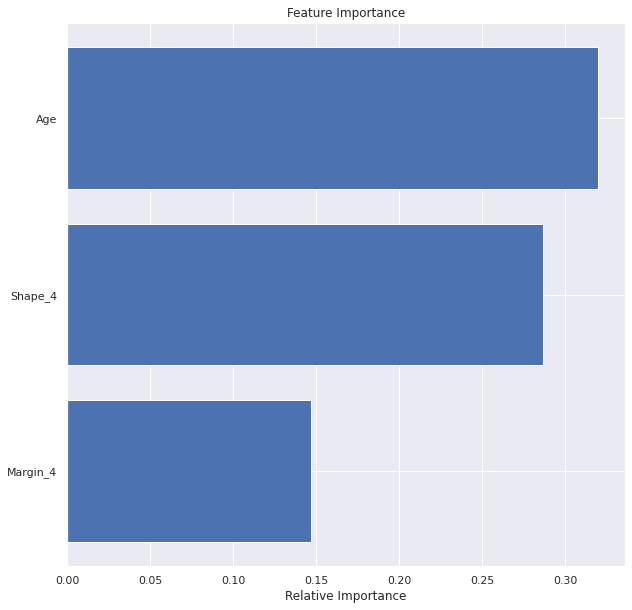

In [35]:
# Create an instance of the Random Forest classifier
rf_model = Random_Forest_Classifier(X_train_s, y_train)

# Fit the Random Forest model to the training data
rf_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_rf = rf_model.predict()

accuracy_rf, classification_report_rf = rf_model.score()
print("The training accuracy achieved by tuned rf model:", accuracy_rf)
print('#'*60)
print("The training classification report of tuned rf model: \n", classification_report_rf)

rf_model.plot_feature_importance(3)

## Model 5: SVM 

Support Vector Machines categorise data by using kernels to map the data to a high-dimensional feature space. A separator between the categories is drawn as a hyperplane. They are memory-efficient, but do not work well on large datasets.

In [36]:
#Used for training only
class SVM_Classifier:
    def __init__(self, X_train, y_train, random_state=42):
        """Initializes the SVM class with the input features X and target variable y,
        and the random state used for reproducibility.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input feature matrix of shape (n_samples, n_features).
        y : pandas.Series
            The target variable of shape (n_samples,).
        random_state : int, default=RANDOM_STATE, which is 42
            The seed value for random number generator used to split the data.

        Returns:
        --------
        None"""

        self.best_params = {}
        self.best_score = 0
        
        self.X_train = X_train
        self.y_train = y_train
              
        self.random_state = random_state
        self.model = SVC(probability=True,random_state=self.random_state)
        
        return
        
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "SVM"
    
    def fit(self, tune_fit="yes"):
        """Trains the model using the input data X and y.
        If tune_fit is set to "yes", it tunes the hyperparameters using GridSearchCV(), otherwise, with default parameters.
        It then stores the best hyperparameters and best estimator in the attributes best_params and model, respectively.

        Parameters:
        -----------
        tune_fit : str, default="yes"
            If "yes", tune the hyperparameters using GridSearchCV(), otherwise use default parameters.

        Returns:
        --------
        None
        """

        if tune_fit=="yes":
            param_grid = {'C': [0.01, 3, 10],
                          'kernel': ['rbf', 'poly'],
                          'gamma': ['scale', 'auto'],
                          'degree':[3,5]
                         }
                                      
            grid_search = GridSearchCV(self.model, param_grid, 
                                       cv=3)
                                       
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)         
                       
        elif tune_fit=="no":
            self.model = self.model.fit(self.X_train, self.y_train)
            print(self.model.get_params()) 
            
        else:
            raise ValueError("Invalid value for `tune_fit`. Must be either 'yes' or 'no'.")
            
        return
            
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit
    
    def predict(self):
        """Predicts the target variable of the test data using the trained svm model.
        Returns the predicted target variable values.

        Parameters:
        -----------
        None

        Returns:
        --------
        numpy.ndarray: The predicted target variable values
        
        """
        return self.model.predict(self.X_train)
    
   
    def score(self):
        """Computes the accuracy score and classification report for the predicted target variable and the actual train target variable.

        Parameters:
        -----------
        None

        Returns:
        --------
        accuracy score: The ratio of the correctly predicted observations to the total observations.
        
        classification report: A text report of the main classification metrics such as precision, recall, f1-score and support for each class."""
        
        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train, y_pred)
        report = classification_report(self.y_train, y_pred)
        print('Number of support vectors: ', self.model.support_.size)
            
        return accuracy, report

In [37]:
# Create an instance of the SVM classifier
svm_model = SVM_Classifier(X_train_s, y_train)

# Fit and tune the SVM model to the training data
svm_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_svm = svm_model.predict()

accuracy_svm, classification_report_svm = svm_model.score()
print("The training accuracy achieved by tuned svm model:", accuracy_svm)
print('#'*60)
print("The training classification report of tuned svm model: \n", classification_report_svm)

{'C': 3, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Number of support vectors:  315
The training accuracy achieved by tuned svm model: 0.8278443113772455
############################################################
The training classification report of tuned svm model: 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       346
           1       0.80      0.85      0.83       322

    accuracy                           0.83       668
   macro avg       0.83      0.83      0.83       668
weighted avg       0.83      0.83      0.83       668



## Model 6: ANN (Artificial Neural Network)

Neural Networks are a form of artificial intelligence that use layers (input layer, output (or target) layer and a middle-hidden layer) that are connected by nodes to form a “network”. Due to the hidden layers, neural networks may be more time-consuming and are often difficult to explain.

In [38]:
#Used for training only
class Neural_Network_Classifier():
    
    def __init__(self, X_train, y_train, hidden_layer_sizes=(8), activation='relu', solver='adam', max_iter=500,random_state=42):
        """Initializes the ann class with the input features X and target variable y,
        and the random state used for reproducibility.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input feature matrix of shape (n_samples, n_features).
        y : pandas.Series
            The target variable of shape (n_samples,).
        random_state : int, default=RANDOM_STATE, which is 42
            The seed value for random number generator used to split the data.

        Returns:
        --------
        None"""
        
        self.best_params = {}
        self.best_score = 0
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.max_iter = max_iter
        self.model = MLPClassifier(hidden_layer_sizes=self.hidden_layer_sizes, activation=self.activation, solver=self.solver, max_iter=self.max_iter,random_state=42)
        
        return
        
    def get_model(self):
        return self.model
    
    def __str__(self):
        return "ANN"    
        
    def fit(self, tune_fit="yes"):
        """Trains the model using the input data X and y.
        If tune_fit is set to "yes", it tunes the hyperparameters using GridSearchCV(), otherwise, with default parameters.
        It then stores the best hyperparameters and best estimator in the attributes best_params and model, respectively.

        Parameters:
        -----------
        tune_fit : str, default="yes"
            If "yes", tune the hyperparameters using GridSearchCV(), otherwise use default parameters.

        Returns:
        --------
        None
        """

        if tune_fit=="yes":
            param_grid = {'hidden_layer_sizes' :[ (9),  (15)],
                          'activation':['identity', 'logistic', 'relu'],
                          'solver': [ 'adam'], 
                          'max_iter':[500, 1000]}
            
            grid_search = GridSearchCV(self.model, param_grid, 
                                       cv=3)
                                      
            grid_search.fit(self.X_train, self.y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            self.model = grid_search.best_estimator_
            print(self.best_params)         
                       
        elif tune_fit=="no":
            self.model = self.model.fit(self.X_train, self.y_train)
            
        else:
            raise ValueError("Invalid value for `tune_fit`. Must be either 'yes' or 'no'.")
            
        return 
    
    def get_fit_model(self):
        final_fit = self.model.fit(self.X_train, self.y_train)
        return final_fit
    
    def predict(self):
        """Predicts the target variable of the test data using the trained model.
        Returns the predicted target variable values.

        Parameters:
        -----------
        None

        Returns:
        --------
        numpy.ndarray: The predicted target variable values
        
        """

        return self.model.predict(self.X_train)
    
    def score(self):
        """Computes the accuracy score and classification report for the predicted target variable and the actual test target variable.

        Parameters:
        -----------
        None

        Returns:
        --------
        accuracy score: The ratio of the correctly predicted observations to the total observations.
        
        classification report: A text report of the main classification metrics such as precision, recall, f1-score and support for each class."""
        
        y_pred = self.predict()
        accuracy = accuracy_score(self.y_train, y_pred)
        report = classification_report(self.y_train, y_pred)
        
        return accuracy, report

In [39]:
# Create an instance of the ANN classifier
ann_model = Neural_Network_Classifier(X_train_s,y_train)

# Fit and tune the ANN model to the training data
ann_model.fit(tune_fit="yes")

# Make predictions on the train data
pred_ann = ann_model.predict()

accuracy_ann, classification_report_ann = ann_model.score()
print("The training accuracy achieved by tuned ann model:", accuracy_ann)
print('#'*60)
print("The training classification report of tuned ann model: \n", classification_report_ann)

{'activation': 'logistic', 'hidden_layer_sizes': 9, 'max_iter': 500, 'solver': 'adam'}
The training accuracy achieved by tuned ann model: 0.8218562874251497
############################################################
The training classification report of tuned ann model: 
               precision    recall  f1-score   support

           0       0.85      0.80      0.82       346
           1       0.80      0.84      0.82       322

    accuracy                           0.82       668
   macro avg       0.82      0.82      0.82       668
weighted avg       0.82      0.82      0.82       668



# Compare Models using test data

We will use the test data that was set aside prior to doing any model-building to compare the performance of the 3 classification model approaches used above.

One of the most commonly used methods to assess results of a classification model is the confusion matrix. The classification models above are all used for assigning each record to one of two classes i.e. benign (0) or malignant (1). 

A confusion matrix is used to categorize counts that line up predicted classes versus actual classes

There are two types of errors that could occur: 

- False positive (FP): a benign mass is mis-classified as malignant 

- False negative (FN): a malignant mass is mis-classified as benign

Using these values, the following can be calculated: Precision = TP/(TP+FP) i.e. proportion of masses classified as malignant that are actually malignant.

- Recall = TP/(TP+FN) i.e. proportion of malignant masses correctly classified as malignant.

- False-alarm rate = FP/(FP+TN) i.e. proportion of benign masses incorrectly classified as malignant.

- False negative rate = FN/(FN+TP) i.e. proportion of malignant masses incorrectly classified as benign.

In the case of a breast-cancer classification, presumably a false negative would be harmful, as someone with breast cancer can be falsely given a clean bill of health. Without early detection, this patient will not be able to receive early intervention, which can lead to a poor future prognosis. However, a low FNR can be achieved by bypassing screening and sending every patient for an invasive biopsy, which is not desirable either. Thus, models will be assessed by several metrics in order to determine the most appropriate approach.

In order to compare the predictive performance of each model, we will plot ROC curves which are a measure of sensitivity of the model and calculate the Area Under the Curve (AUC). A higher AUC indicates a model with more predictive power.




# Current Methodology for Classifying Mammogram Masses

Under the current methodology, mammogram masses are examined by radiologists, and a BI-RADS assessment is assigned. According to https://radiopaedia.org/articles/breast-imaging-reporting-and-data-system-bi-rads the assessment is interpreted as follows:
0 - incomplete (repeat mammogram)
1 - negative
2 - benign 
3 - likely benign (<2% probability of malignancy). Follow up in shortened interval.
4 - suspected malignant (biopsy recommended)
5 - highly likely to be malignant
6 - malignant but only assigned after biopsy confirmation

For our analysis, we will remove any observations with 0 or 6, and will group 1-3 as negative, and 4-5 as positive.

In [40]:
# create a dataframe with only the BI-RADS assessment and Severity columns
# Remove any rows with missing bi-rads values
birads = mammogramdata.loc[:, ['BI-RADS assessment', 'Severity']]


birads['BI-RADS assessment'] = birads['BI-RADS assessment'].replace({'0':np.nan,'6':np.nan, '55':'5'}).dropna()
birads.value_counts()

# replace BI-RADS assessment with a 0 or 1, based on information from *****
birads['BI-RADS assessment'] = birads['BI-RADS assessment'].replace({'1':0, '2':0, '3':0, '4':1, '5':1})
birads['BI-RADS assessment'].value_counts()


#calculate values for confusion matrix
truepositive = sum((birads['BI-RADS assessment'] == 1) & (birads['Severity'] == 1))
falsepositive = sum((birads['BI-RADS assessment'] == 1) & (birads['Severity'] == 0))
falsenegative = sum((birads['BI-RADS assessment'] == 0) & (birads['Severity'] == 1))
truenegative = sum((birads['BI-RADS assessment']  == 0) & (birads['Severity'] == 0))
print(truepositive, falsepositive, falsenegative, truenegative)

# Create and display confusion matrix
birad_cm = np.array([[truenegative, falsepositive],[falsenegative, truepositive]])
birad_cm

# From this summary it appears that the majority of mammogram masses (over 90%) are classified as malignant under
# the BI-RADS assessment. 

426 467 7 43


array([[ 43, 467],
       [  7, 426]])

In [41]:
br_acc = round((truepositive+truenegative)/(len(birads))*100,2)
br_prec = round(truepositive/(truepositive+falsepositive)*100,2)
br_far = round(falsepositive/(falsepositive+truenegative)*100,2)
br_fnr = round(falsenegative/(falsenegative+truepositive)*100,2)

print("The accuracy for BI-RADS assessment is:",br_acc,'%')
print("The precision for BI-RAD S assessment is:",br_prec,'%')
print("The false alarm rate for BI-RADS assessment is:",br_far,'%')
print("The false negative Rate for BI-RADS assessment is:",br_fnr,'%')

The accuracy for BI-RADS assessment is: 48.8 %
The precision for BI-RAD S assessment is: 47.7 %
The false alarm rate for BI-RADS assessment is: 91.57 %
The false negative Rate for BI-RADS assessment is: 1.62 %


In [42]:
class Predict_Model:
    def __init__(self, model_class, X_test, y_test):
        self.model_class = model_class
        self.model = model_class.get_model()
        self.X_test = X_test
        self.y_test = y_test

    def predictions(self):
        return self.model.predict(self.X_test)
    
    
    def confMatrix(self):
        y_predict = self.predictions()
        print(confusion_matrix(self.y_test, y_predict))
        print('Classification Report for',str(self.model_class),'\n',classification_report(self.y_test, y_predict)) 
        return 
        
    #Calculate metrics for each model using test data:
    def calcMetrics(self):
        y_pred = self.predictions()
        tn, fp, fn, tp = confusion_matrix(list(self.y_test), list(y_pred), labels=[0, 1]).ravel()
        acc = round((tp+tn)/(tp+tn+fp+fn) *100,2)
        prec = round((tp)/(tp+fp) *100,2)
        far = round((fp)/(fp+tn) *100,2)
        fnr = round(fn/(fn+tp) *100,2)
        return acc, prec, far, fnr

In [43]:
print("Testing Logistic Regression on test data \n")
pred_lr = Predict_Model(lr_model,X_test_s,y_test)
pred_lr.confMatrix()
lr_acc, lr_prec, lr_far, lr_fnr = pred_lr.calcMetrics()

print("Testing Decision Tree on test data \n")
pred_dt = Predict_Model(dt_model,X_test_s,y_test)
pred_dt.confMatrix()
dt_acc, dt_prec, dt_far, dt_fnr = pred_dt.calcMetrics()

print("Testing KNN on test data \n")
pred_knn = Predict_Model(knn_model,X_test_s,y_test)
pred_knn.confMatrix()
kn_acc, kn_prec, kn_far, kn_fnr = pred_knn.calcMetrics()

print("Testing Random Forest on test data \n")
pred_rf = Predict_Model(rf_model,X_test_s,y_test)
pred_rf.confMatrix()
rf_acc, rf_prec, rf_far, rf_fnr = pred_rf.calcMetrics()

print("Testing SVM on test data \n")
pred_svm = Predict_Model(svm_model,X_test_s,y_test)
pred_svm.confMatrix()
sv_acc, sv_prec, sv_far, sv_fnr = pred_svm.calcMetrics()

print("Testing ANN on test data \n")
pred_ann = Predict_Model(ann_model,X_test_s,y_test)
pred_ann.confMatrix()
nn_acc, nn_prec, nn_far, nn_fnr = pred_ann.calcMetrics()

Testing Logistic Regression on test data 

[[58 24]
 [10 76]]
Classification Report for Logistic Regression 
               precision    recall  f1-score   support

           0       0.85      0.71      0.77        82
           1       0.76      0.88      0.82        86

    accuracy                           0.80       168
   macro avg       0.81      0.80      0.80       168
weighted avg       0.81      0.80      0.80       168

Testing Decision Tree on test data 

[[55 27]
 [13 73]]
Classification Report for Decision Tree 
               precision    recall  f1-score   support

           0       0.81      0.67      0.73        82
           1       0.73      0.85      0.78        86

    accuracy                           0.76       168
   macro avg       0.77      0.76      0.76       168
weighted avg       0.77      0.76      0.76       168

Testing KNN on test data 

[[59 23]
 [ 9 77]]
Classification Report for KNN 
               precision    recall  f1-score   support

     

## Compare machine learning classification methods

In [44]:
class Roc_Curve:
    def __init__(self, list_model_class,X_test,y_test):
        self.list_model_class = list_model_class
        self.X_test = X_test
        self.y_test = y_test
    
    def plot_roc_curve(self):
        y_probs = []
        r_curves = {}
        for model_class in self.list_model_class:
            y_predict= model_class.get_fit_model().predict_proba(self.X_test)[:,1]
            y_probs.append(y_predict)
            false_pos, sens, thresh = roc_curve(self.y_test, y_predict)
            auc_model = metrics.roc_auc_score(self.y_test, y_predict)
            r_curves[model_class] = [false_pos, sens, thresh, auc_model]
            
        for model in r_curves:
            plt.plot(r_curves[model][0], r_curves[model][1], label = "{} (auc = {} )".format(str(model), round(r_curves[model][3],2)))

        plt.ylabel("Sensitivity")
        plt.xlabel("False Positive Rate")
        plt.title("ROC curve for Classification Models", fontsize=16);
        plt.legend();
        plt.show()
        return 

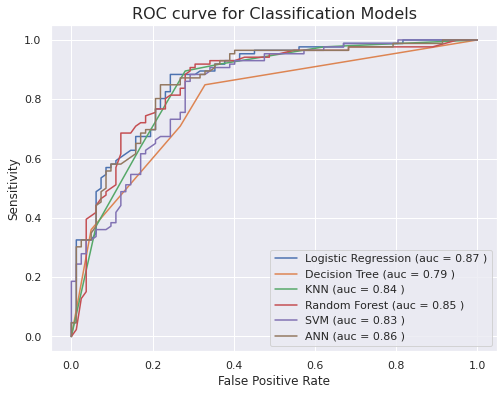

In [45]:
list_models = [lr_model, dt_model, knn_model,rf_model, svm_model,ann_model]
roc = Roc_Curve(list_models, X_test_s, y_test)
roc.plot_roc_curve()

# Discussion

Comparing the classificaiton models explored in this analysis, it appears that the K-Nearest Neighbours produced the highest test accuracy, while the Decision Tree has the lowest test accuracy. The remaining models have similar test accuracies around 80% . The RF model produced a false alarm rate of 28% and a false negative rate of 12%, which were among the lowest of all the models.

Plotting the sensitivity measure against the false positive rate produces the Receiver Operating Characteristic (ROC) curve. This curve can be used to determine the optimal threshold at which the classes should be defined. The Area Under the Curve (AUC) provides the total measure of performance across all possible thresholds for a model. Comparing the AUC measure, the logistic regression model had the highest value of 87%, while the AUC for the neural network was just slightly lower at 86%. Again, the decision tree performed the worst based on AUC.


In [46]:
models = [('Logistic Regression', lr_acc, lr_prec, lr_far, lr_fnr),
         ('Decision Tree', dt_acc, dt_prec, dt_far, dt_fnr),
         ('K-Nearest Neighbours', kn_acc, kn_prec, kn_far, kn_fnr),
         ('Random Forest', rf_acc, rf_prec, rf_far, rf_fnr),
         ('Support Vector Machine', sv_acc, sv_prec, sv_far, sv_fnr),
         ('Neural Network', nn_acc, nn_prec, nn_far, nn_fnr)]

display = pd.DataFrame(data=models,
                      columns = ['Model', 'Accuracy','Precision',
                                 'False Alarm Rate', 'False Negative Rate']).set_index('Model')
display.round(0)

,Accuracy,Precision,False Alarm Rate,False Negative Rate
Model,,,,
Logistic Regression,80.0,76.0,29.0,12.0
Decision Tree,76.0,73.0,33.0,15.0
K-Nearest Neighbours,81.0,77.0,28.0,10.0
Random Forest,80.0,77.0,28.0,12.0
Support Vector Machine,80.0,76.0,29.0,12.0
Neural Network,80.0,77.0,27.0,13.0


In [47]:
models = [('Logistic Regression', accuracy_lr*100, lr_acc),
         ('Decision Tree', accuracy_dt*100, dt_acc),
         ('K-Nearest Neighbours', accuracy_knn*100, kn_acc),
         ('Random Forest', accuracy_rf*100, rf_acc),
         ('Support Vector Machine', accuracy_svm*100, sv_acc),
         ('Neural Network', accuracy_ann*100, nn_acc)]

displayAcc = pd.DataFrame(data=models,
                      columns = ['Model', 'Training Accuracy','Test Accuracy']).set_index('Model')
displayAcc.round(1)

,Training Accuracy,Test Accuracy
Model,,
Logistic Regression,81.9,79.8
Decision Tree,79.3,76.2
K-Nearest Neighbours,84.3,81.0
Random Forest,81.4,80.4
Support Vector Machine,82.8,79.8
Neural Network,82.2,80.4


# Conclusion

The analysis indicates that machine learning algorithms can outperforms the current BI-RADS assessment based on both accuracy and precision. In particular, the BI-RADS assessment produces a very high the false alarm rate (over 90%), which means that a large number of patients would be subjected to unnecessary follow-up procedures. 


In order to further explore the use of machine learning tools in predicting whether mammogram masses are benign or malignant, it would be useful to gather additional data, including more features such as actual measurements and location. This can serve to improve model performance and provide even higher levels of accuracy and precision, while reducing the false alarm and false negative rates.
 
 
 